Some usage examples. Requires a trajectory (preferrable xtc or dcd format) and pdb (or alternative topology).

In [14]:
from src import *
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

First let's construct and plot a temporal adjacency graph

coords loaded (35, 3, 2344003)
coords aligned (23441, 35, 3)
got contact maps
Frames: 23441 N: 35 Unique maps: 23029


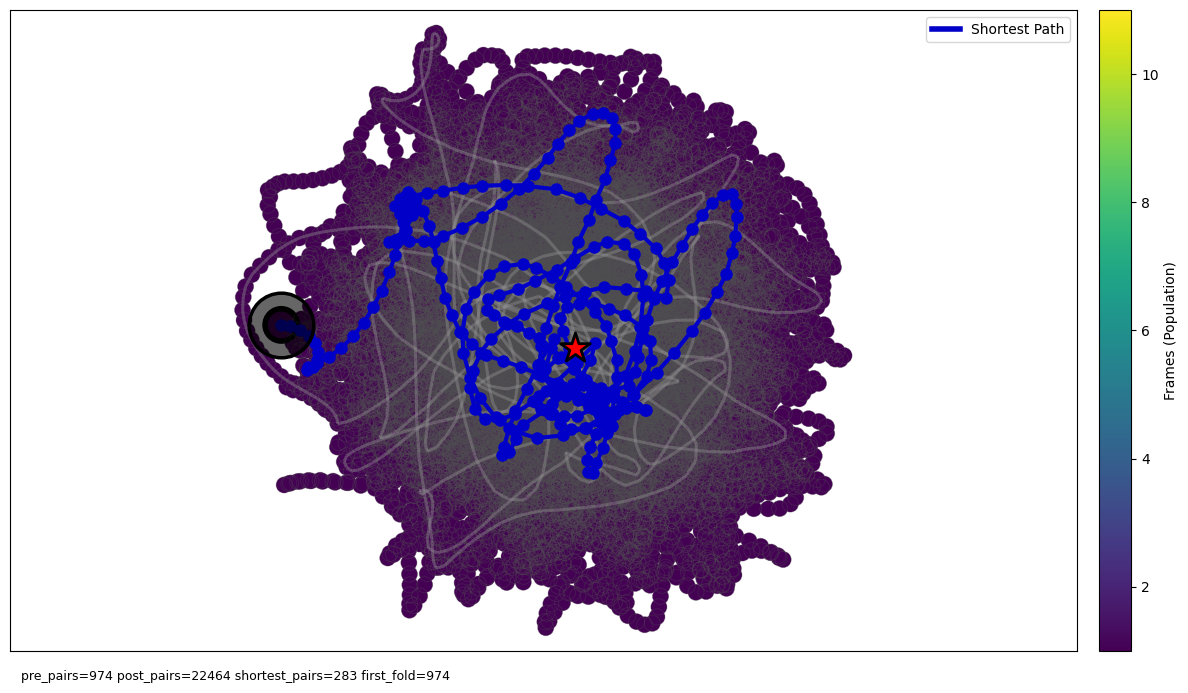

In [15]:
import MDAnalysis as mda

pdb = "/Users/kebl8116-admin/Projects/origami/data/fast-folders/experimental_structures/villin_2f4k.pdb"
coords = np.load("/Users/kebl8116-admin/Projects/origami/data/fast-folders/villin_ca_coords.npy")
print("coords loaded", coords.shape)
coords = coords.transpose(2, 0, 1).copy()
coords = contacts.align_traj(coords[::100,:,:] , ref=coords[-1])
print("coords aligned", coords.shape)

# sanity checks
assert coords.ndim == 3 and coords.shape[2] == 3
n_frames, n_atoms_coords, _ = coords.shape

u_full = mda.Universe(pdb)
ca = u_full.select_atoms("name CA")

assert coords.shape[1] == ca.n_atoms

u = mda.Merge(ca) # Build CA-only topology
u.load_new(coords, order="fac") # Attach trajectory
contact_maps = contacts.get_contact_maps(u, seq_sep=5)
print("got contact maps")

# extract list of unique contact maps (N,N)
unique_maps, frame_to_uid, inds = contacts.get_unique_maps(contact_maps)

# build a graph whose edges represent temporal adjacency
G, counter, node_counts = graphs.build_temporal_transition_graph(frame_to_uid, inds, keep_self_loops=False)
# plot it as a static image with edges weighted by transitions counts
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=True,
                                   title="", post_fold_red=False)
plt.show()

<Axes: >

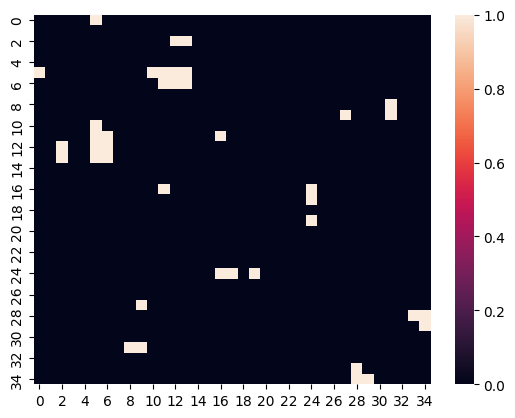

In [17]:
u = mda.Universe(pdb)
native_contact_map = contacts.get_contact_maps(u=u, seq_sep=5)[0] # get contact map
sns.heatmap(native_contact_map)


For a contact space manifold graph we get bit representations of contact maps for hamming distance comparison to determine manifold edges

In [18]:
# convert unique maps to bit integer representations instead of N,N contact map matrices
# ints is the list of unique contact map bit integers for each frame in trajectory
ints, Mbits, _ = contacts.maps_to_upper_ints(unique_maps)

# build graph with edges representing hamming difference of 1
# so connect nodes that are adjacent in the contact space manifold (1 contact flip apart)
Gm, ints = graphs.build_contact_manifold_graph(ints, Mbits, method='auto')

# get node counts as contact map state populations
U = int(np.max(frame_to_uid)) + 1
node_counts = np.bincount(frame_to_uid, minlength=U)

# then collect temporal edges and transition count information
edge_info = graphs.temporal_edge_counts(frame_to_uid, keep_self_loops=False)

# now merge manifold and temporal graphs
G = graphs.merge_manifold_and_temporal(Gm, edge_info, node_counts=node_counts) # and merge

start_node = int(frame_to_uid[0]) # assume start node is first
folded_node = int(np.argmax(np.bincount(frame_to_uid))) # and folded node most populated

# shortest path along manifold graph only (Gm)
# could provide G instead to get shortest path operating on manifold and temporal edges
path_m = nx.shortest_path(Gm, source=start_node, target=folded_node)
# custom path overlays
custom_paths = {
    'Manifold Geodesic': path_m
}

# this plotting function by default plots the shortest path over manifold+temporal edges (blue)
# with above custom_paths with path_m we ad violet manifold geodesic path
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=True,
                                   custom_paths=custom_paths, post_fold_red=False,
                                   title="")
plt.show()

NetworkXNoPath: No path between 0 and 974.

For the plotting coordinates to be meaningful in the contact map space we must embed the high dimensional N,N (or compressed bit/integer representations which still live on the hypercube) maps to 2D

/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/kebl8116-admin/miniconda3/envs

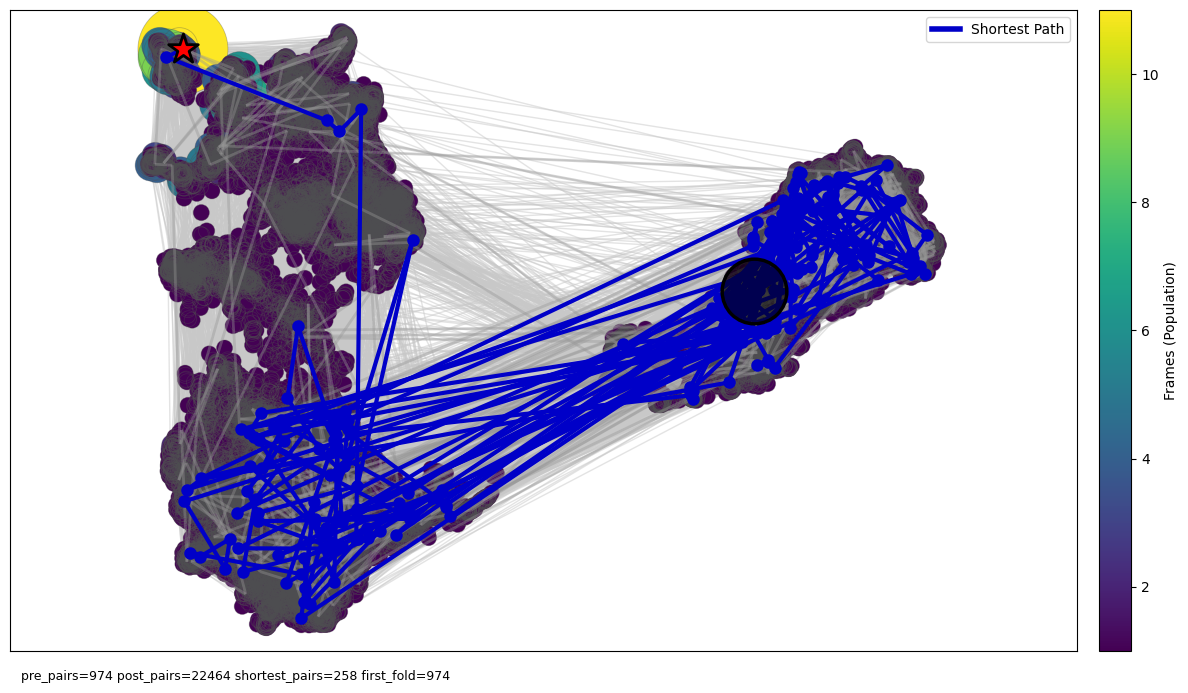

In [20]:
# flatten unique N,N contact maps upper triangles to flat bits and convert to integer representations
flat_bits, _, Mbits = contacts.flatten_upper_bits(unique_maps) # we get the actual bits here for later use
ints, Mbits, _ = contacts.maps_to_upper_ints(unique_maps) # and also use this function which uses the above then converts the flat bits into ints

# construct the manifold graph from ints representation
Gm, ints = graphs.build_contact_manifold_graph(ints, Mbits, method='auto')
# again merge the temporal edge infos
edge_info = graphs.temporal_edge_counts(frame_to_uid, keep_self_loops=False)
G = graphs.merge_manifold_and_temporal(Gm, edge_info, node_counts=node_counts)

# now we perform the embedding with the flattened bits (not integers)
# using pca followed by umap
X_emb, pca = clustering.embed_flat_bits(flat_bits, pca_n=45, umap_n=2)

# we can extract x, y positions from the first embeddings
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}
custom_paths = {}
# plot
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, pos, X_emb, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=False,
                                   custom_paths=custom_paths, post_fold_red=False,
                                   title="")
plt.show()

In [8]:
path_m

[0, 112, 4]

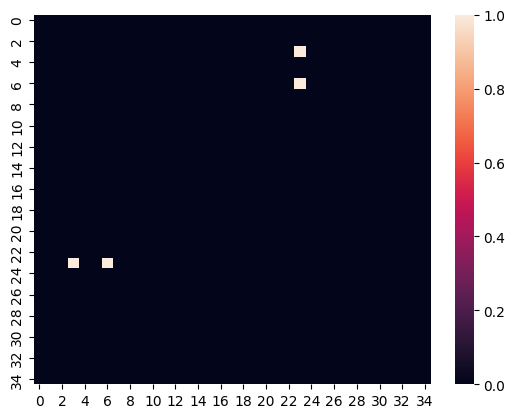

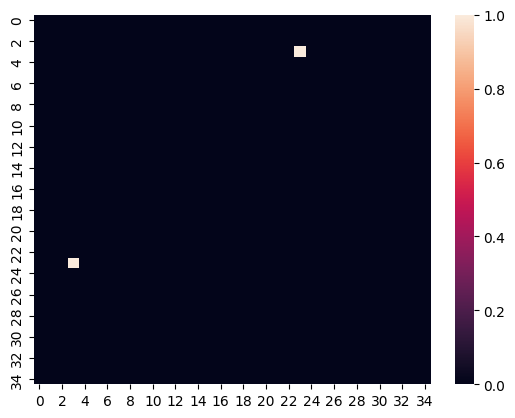

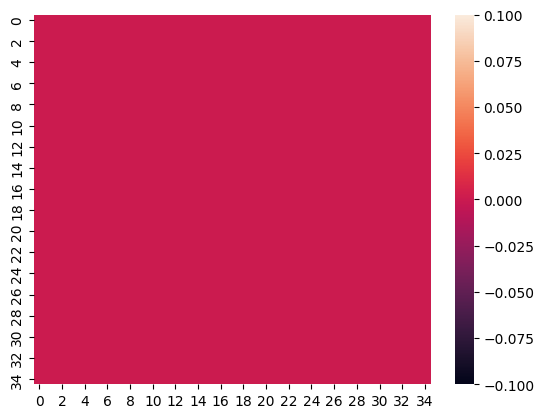

In [10]:
import seaborn as sns
for n in path_m:
    sns.heatmap(unique_maps[n])
    plt.show()

Same as above but instead use MDS embedding for more maningful geometric distances.

/Users/kebl8116-admin/Projects/protein_folding_graphs/src/clustering.py:146: UserWarning: U=12716 large: pairwise Hamming (U^2) will be expensive and memory-heavy.
  warnings.warn(f"U={U} large: pairwise Hamming (U^2) will be expensive and memory-heavy.", UserWarning)
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a

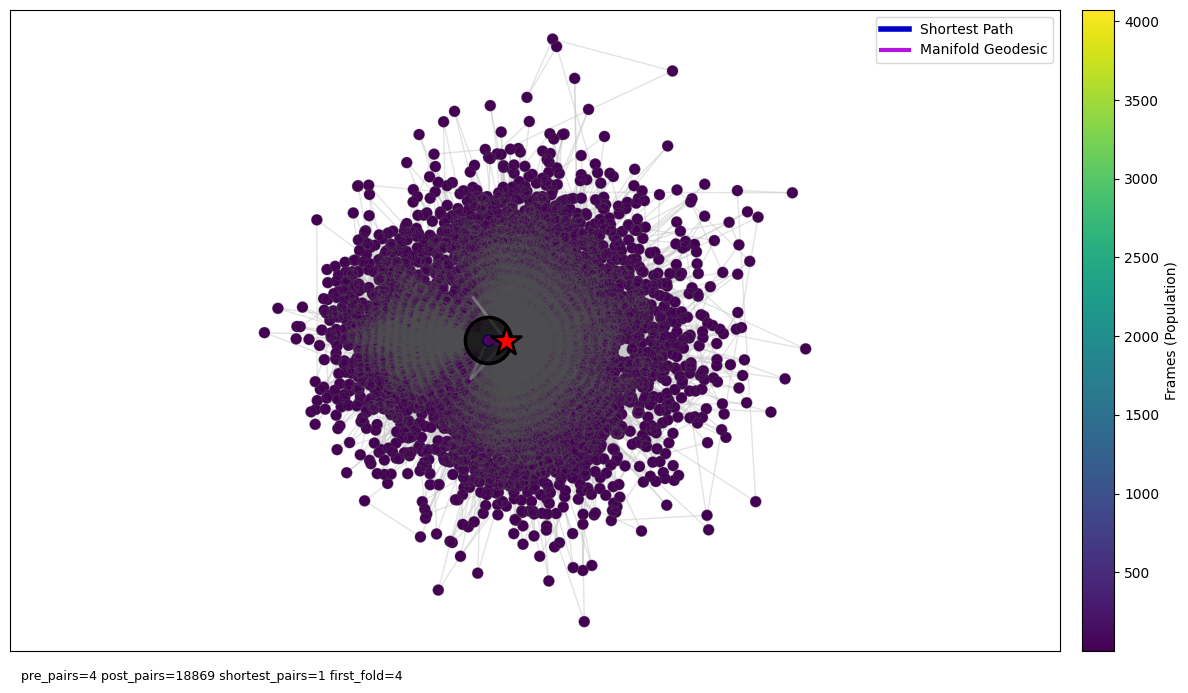

In [6]:
# embedd int representations by MDS
X_emb, labels, D = clustering.embed_and_cluster_by_hamming(ints,
                                 n_components=2,
                                 embed_method='mds',   # 'mds' or 'spectral'
                                 cluster_method='agglomerative',  # 'agglomerative' or 'hdbscan'
                                 n_clusters=None,      # only for agglomerative
                                 random_state=42,
                                 warn_threshold=4000)
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}

fig, ax = plotting.plot_graph_auto(G, frame_to_uid, pos, X_emb, unique_maps=unique_maps, unique_indices=inds, interactive=False,
                                   custom_paths=custom_paths, post_fold_red=False,
                                   title="")
plt.show()

Now let's compute committor probabilities and plot them

/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_87094/3294828948.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("RdBu")


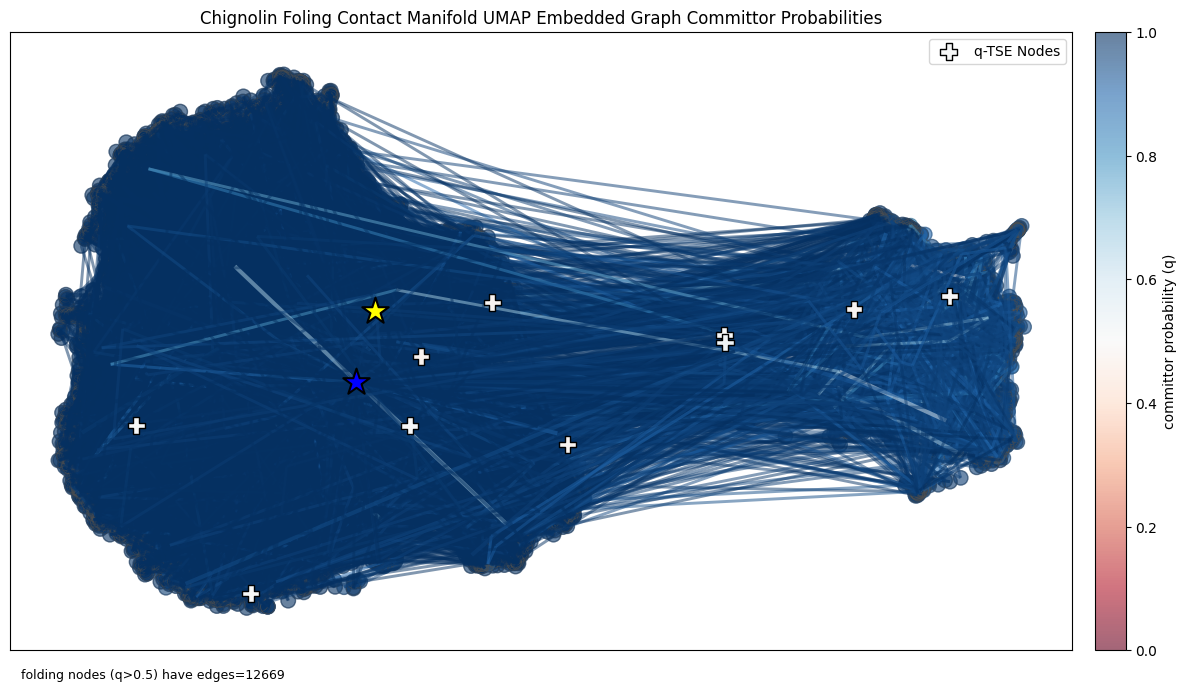

In [7]:
import matplotlib as mpl
from matplotlib.collections import LineCollection
import umap

def embed_flat_bits(flat_bits, n_components=2, n_neighbors=15, random_state=42):
    """
    embed flat_bits (U, Mbits) -> X_emb (U,2)
    Prefer UMAP if available, else Isomap, else SpectralEmbedding, else PCA.
    """
    X = flat_bits.astype(float)  # scikit-learn expects float arrays
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
    X_emb = reducer.fit_transform(X)
    return X_emb

X_emb = embed_flat_bits(flat_bits, n_neighbors=15)
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}

# compute committor probabilities for each node
q_map = graph_analysis.compute_committor_reversible(G, start_node, folded_node, use_direct_solver=True)
nx.set_node_attributes(G, q_map, 'committor')

fig, ax = plt.subplots(figsize=(12, 7))

node_q_colors = np.array([q_map[i] for i in range(len(G.nodes()))])

sizes = 10 + 100*np.array(list(q_map.values()))
x = [pos[i][0] for i in G.nodes]
y = [pos[i][1] for i in G.nodes]
sc = ax.scatter(x, y, c=node_q_colors, s=sizes, alpha=0.6, cmap="RdBu")
for i in G.nodes:
    lw = 0.6
    ec = (80/255,80/255,80/255,0.35)
    if i == start_node: lw = 4.0; ec = (0,0,0,1) # special outline for start node (black)
    ax.scatter([x[i]], [y[i]], s=max(1, sizes[i]), facecolors='none', edgecolors=[ec], linewidths=lw, zorder=2.1)

# 1. Sort all nodes by how close their q is to 0.5
# We use abs(q - 0.5) as the sorting key (smallest difference = best TSE candidate)
sorted_tse_candidates = sorted(
    q_map.items(), 
    key=lambda item: abs(item[1] - 0.5)
)

q_tse = sorted_tse_candidates[:10]
q_tse_ids = [node_id for node_id, q_val in q_tse]
star_x = [pos[n][0] for n in q_tse_ids]
star_y = [pos[n][1] for n in q_tse_ids]

q_tse_sizes = [300*b[1] for b in q_tse]

cmap = mpl.cm.get_cmap("RdBu")
norm = mpl.colors.Normalize(
    vmin=np.array(node_q_colors).min(),
    vmax=np.array(node_q_colors).max()
)

ax.scatter(
    star_x, 
    star_y, 
    c=np.array(node_q_colors)[q_tse_ids],        # Color
    cmap=cmap,
    norm=norm,
    marker='P',     # Star shape
    s=q_tse_sizes,          # Size (make it visible)
    edgecolors='black', # Optional: black outline for contrast
    linewidths=1,
    label='q-TSE Nodes',
    zorder=20,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper right')

ax.scatter(
    pos[117][0], 
    pos[117][1], 
    c="yellow", 
    marker='*',     # Star shape
    s=400,          # Size (make it visible)
    edgecolors='black', # Optional: black outline for contrast
    linewidths=1.5,
    zorder=21,
)

ax.scatter(pos[start_node][0], pos[start_node][1], c="black", s=200, label="Start Node", alpha=0.7)
ax.scatter(pos[folded_node][0], pos[folded_node][1], c="blue", s=400, marker="*", linewidths=1.5, edgecolors="black", label="Folded Node", zorder=20)

# If we consider "folding_nodes" as those with q > 0.5
folding_nodes = {}
all_nodes = {}
for n, q in q_map.items():
    contact_map = unique_maps[n]
    if contact_map[1,6] == 1:
        all_nodes[n] = 1
        if q > 0.5:
            folding_nodes[n] = 1
    else: 
        all_nodes[n] = 0
        if q > 0.5:
            folding_nodes[n] = 0

folding_nodes_idxs = list(folding_nodes.keys())
folding_nodes_edges = plotting.expand_seq_to_edges(G, folding_nodes_idxs, True, count_multiplicity=True)

folding_segs, widths = plotting.pairs_and_widths_from_edges(folding_nodes_edges, pos, base_w=0.1, scale_w=2)

# get edge colors based on destination node value
edge_colors = []
for edge, count in folding_nodes_edges.items():
    q_value = q_map.get(edge[1], 0) 
    edge_colors.append(cmap(norm(q_value)))

lc = LineCollection(folding_segs, colors=edge_colors, linewidths=widths, zorder=6, alpha=0.5)
ax.add_collection(lc)

cbar = fig.colorbar(sc, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("committor probability (q)")

ax.set_aspect('equal', adjustable='datalim')
ax.set_xticks([]); ax.set_yticks([])
ax.set_title("Chignolin Foling Contact Manifold UMAP Embedded Graph Committor Probabilities")

# debug text
dbg = f"folding nodes (q>0.5) have edges={len(folding_nodes_idxs)}"
ax.text(0.01, -0.03, dbg, transform=ax.transAxes, fontsize=9, va='top')

plt.tight_layout()
plt.savefig("images/chignolin_manifold_umap_graph_qtse_seqsep_fixed.png")
plt.show()


What about physics based graphs?

  - Constrained to Manifold: 559 edges (removed jumps)
  - Constrained to Manifold: 559 edges (removed jumps)
Solving Eigenvalues for 207 microstates...


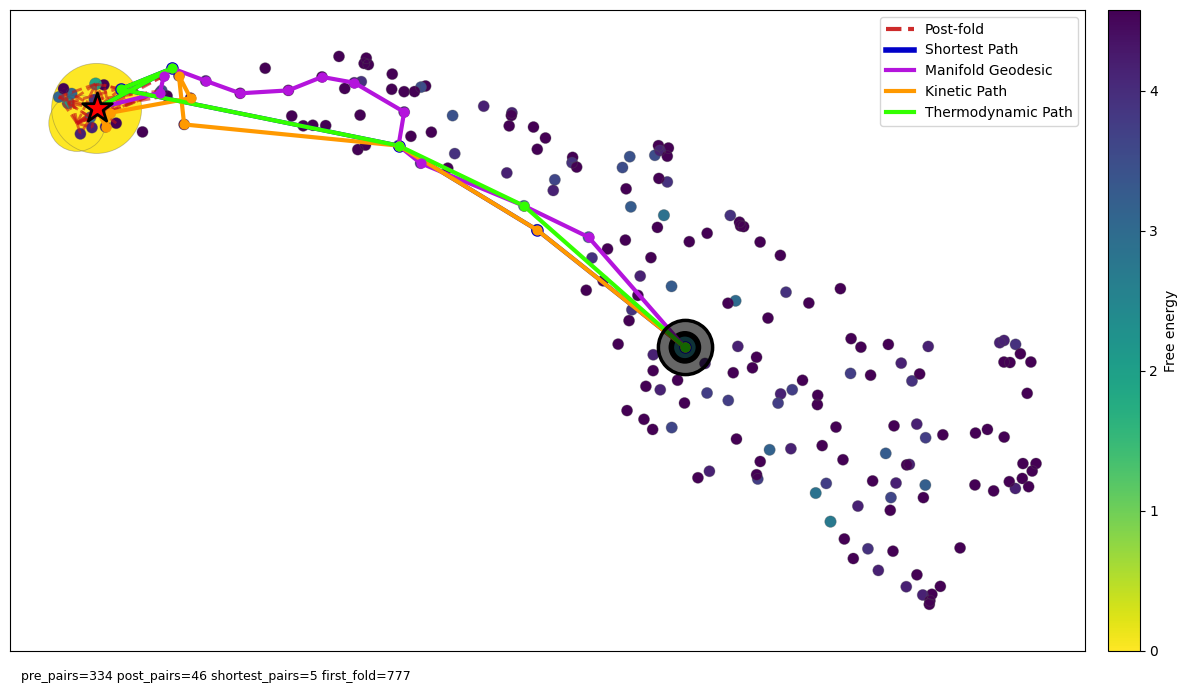

In [17]:
'''
PHYSICS GRAPHS with shortest paths NOT restricted to manifold edges
'''
start_node = int(frame_to_uid[0])
folded_node = int(np.argmax(np.bincount(frame_to_uid)))

# kinetic method based on transition probabilities
G_kinetic = graph_analysis.build_physics_graph(G, physics_mode="kinetic", 
                            restrict_to_manifold=True, 
                            frame_to_uid=frame_to_uid)
path_kinetic = nx.shortest_path(G_kinetic, source=start_node, target=folded_node, weight='weight')

# thermodynamic method based on Boltzmann Inversion
G_therm = graph_analysis.build_physics_graph(G, physics_mode="thermodynamic", 
                            restrict_to_manifold=True, 
                            frame_to_uid=frame_to_uid)
path_therm = nx.shortest_path(G_therm, source=start_node, target=folded_node, weight='weight')

# paths for plotting
custom_paths = {
    "Manifold Geodesic": path_m,
    "Kinetic Path": path_kinetic,
    "Thermodynamic Path": path_therm
}

# Let's actually compute proper free energies with a MSM approach
G = graph_analysis.enforce_detailed_balance(G)
MSM = graph_analysis.free_energy_analysis(G)

true_folded_node = MSM['folded_node'] # this gives us a physics-based approximation of the true folded node

F_map = MSM['free_energy'] # free energies for each node
nx.set_node_attributes(G, F_map, 'free_energy')

# Map F values to the embedding
num_nodes = X_emb.shape[0]
f_colors = [F_map.get(i, 10.0) for i in range(num_nodes)] # Default high energy if missing

fig, ax = plotting.plot_graph_auto(
    G_kinetic, frame_to_uid, pos=pos, X_emb=X_emb,
    unique_maps=unique_maps,
    unique_indices=inds,
    start_frame=start_node,
    folded_node=true_folded_node,
    show_shortest=True,
    show_bg=False,
    custom_paths=custom_paths,
    custom_paths_colors=[(180/255, 20/255, 220/255, 1.0), (1.0, 0.6, 0, 1.0), (0.2, 1.0, 0, 1.0)],
    node_custom_color=f_colors,
    node_custom_color_title="Free energy",
    palette="viridis_r",  
    interactive=False,
    title=""
)
plt.show()

Plotting on reaction coordinates and free energy (x,y) instead of embeddings

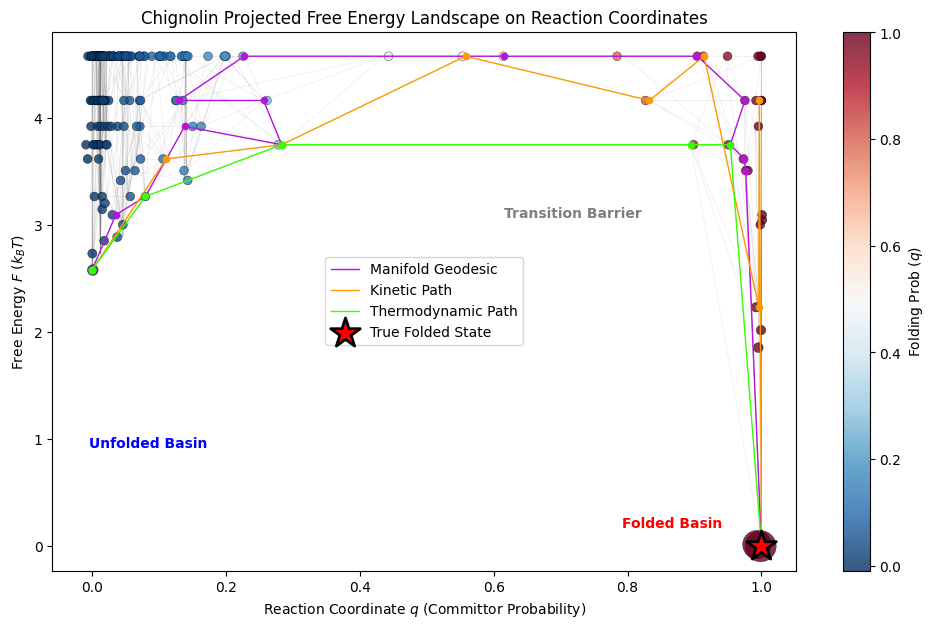

In [18]:
import pandas as pd 
from matplotlib.collections import LineCollection

node_counts = pd.Series(frame_to_uid).value_counts()
node_list = list(G.nodes())

custom_paths_colors=[(180/255, 20/255, 220/255, 1.0), (1.0, 0.6, 0, 1.0), (0.2, 1.0, 0, 1.0)]

# and node sizes by frame counts
frame_counts = plotting.ensure_frame_counts(G, frame_to_uid)
max_node_size = 500
min_node_size = 40
node_sizes = min_node_size + (frame_counts / max(1, frame_counts.max())) * (max_node_size - min_node_size)

fig, ax = plotting.plot_energy_landscape(G, q_map, F_map, custom_paths=custom_paths, custom_paths_colors=custom_paths_colors, folded_node=folded_node,
    node_sizes=node_sizes, figsize=(12,7), legend_location="center"
)
plt.show()

Estimate transition state ensemble with committor probabilities

In [19]:
# TSE is defined as states with q approx 0.5 (0.35 to 0.65)
tse_nodes = [n for n, q in q_map.items() if 0.35 <= q <= 0.65]
print("TSE: ", tse_nodes)

TSE:  [178, 179, 187]


Finally let's determine the contact flip kinetic barriers for each native contact pair

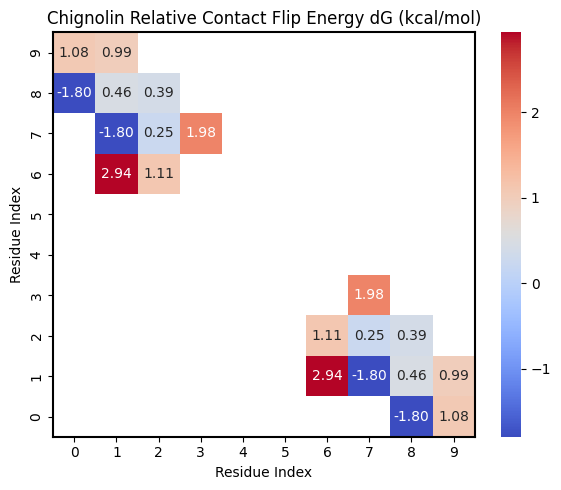

In [24]:
'''
Use most populated frame as folded node still
'''

# infer contact flip energies from the graph
G_energy, df, results = contact_energies.infer_contact_flip_energies_from_graph(G, ints=ints, node_state_attr=G.nodes, Gm=Gm)

res_pairs_native = np.argwhere(np.triu(unique_maps[folded_node], k=1) == 1) # get native contact residue pairs
N = unique_maps[folded_node].shape[1]

# for each native contact get the respective energy from our energies dataframe
contact_energies_matrix = np.full((N,N), np.nan, dtype=float)
for native_pair in res_pairs_native:
    i, j = native_pair
    try:
        contact_energies_matrix[i, j] = df.loc[df['residue_pair'] == tuple(native_pair), 'dG_rel_kcal_per_mol'].iloc[0]
        contact_energies_matrix[j, i] = df.loc[df['residue_pair'] == tuple(native_pair), 'dG_rel_kcal_per_mol'].iloc[0]
    except:
        print(native_pair, "not found in df_contacts")
        contact_energies_matrix[i, j] = np.nan
        contact_energies_matrix[j, i] = np.nan

# PLOT
import seaborn as sns
plt.figure(figsize=(6, 5))
ax = sns.heatmap(contact_energies_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0,
    cbar=True
)
ax.invert_yaxis()

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1.5)

plt.title("Chignolin Relative Contact Flip Energy dG (kcal/mol)")
plt.ylabel("Residue Index")
plt.xlabel("Residue Index")
plt.tight_layout()
plt.show()

Butwe can also use the pdb structure as its native contacts are slightly different

[0 1] not found in df_contacts
[0 2] not found in df_contacts
[1 2] not found in df_contacts
[1 3] not found in df_contacts
[2 3] not found in df_contacts
[2 4] not found in df_contacts
[2 5] not found in df_contacts
[3 4] not found in df_contacts
[3 5] not found in df_contacts
[3 6] not found in df_contacts
[4 5] not found in df_contacts
[4 6] not found in df_contacts
[5 6] not found in df_contacts
[5 7] not found in df_contacts
[6 7] not found in df_contacts
[6 8] not found in df_contacts
[7 8] not found in df_contacts
[7 9] not found in df_contacts
[8 9] not found in df_contacts


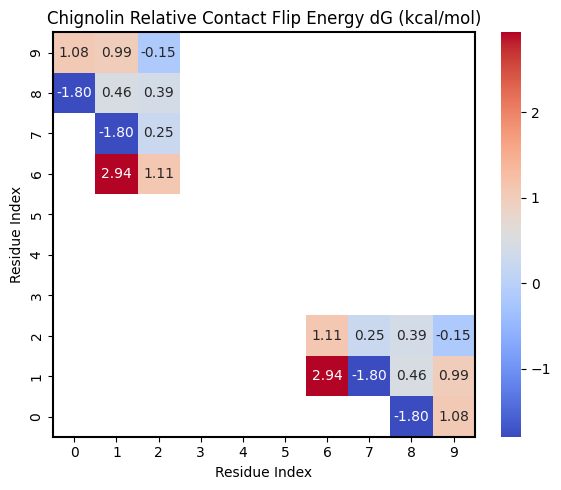

In [26]:
'''
Use pdb as native contact map for native contacts
'''

import MDAnalysis as mda

# get native contacts from native structure pdb
u = mda.Universe("/Users/kebl8116-admin/Projects/origami/data/Chignolin/5awl.pdb")
native_contact_map = contacts.get_contact_maps(u=u, seq_sep=0)[0] # get contact map

res_pairs_native = np.argwhere(np.triu(native_contact_map, k=1) == 1) # get native contact residue pairs
N = native_contact_map.shape[1]

# for each native contact get the respective energy from our energies dataframe
contact_energies_matrix = np.full((N,N), np.nan, dtype=float)
for native_pair in res_pairs_native:
    i, j = native_pair
    try:
        contact_energies_matrix[i, j] = df.loc[df['residue_pair'] == tuple(native_pair), 'dG_rel_kcal_per_mol'].iloc[0]
        contact_energies_matrix[j, i] = df.loc[df['residue_pair'] == tuple(native_pair), 'dG_rel_kcal_per_mol'].iloc[0]
    except:
        print(native_pair, "not found in df_contacts")
        contact_energies_matrix[i, j] = np.nan
        contact_energies_matrix[j, i] = np.nan

# PLOT
import seaborn as sns
plt.figure(figsize=(6, 5))
ax = sns.heatmap(contact_energies_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0,
    cbar=True
)
ax.invert_yaxis()

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1.5)

plt.title("Chignolin Relative Contact Flip Energy dG (kcal/mol)")
plt.ylabel("Residue Index")
plt.xlabel("Residue Index")
plt.tight_layout()
plt.show()

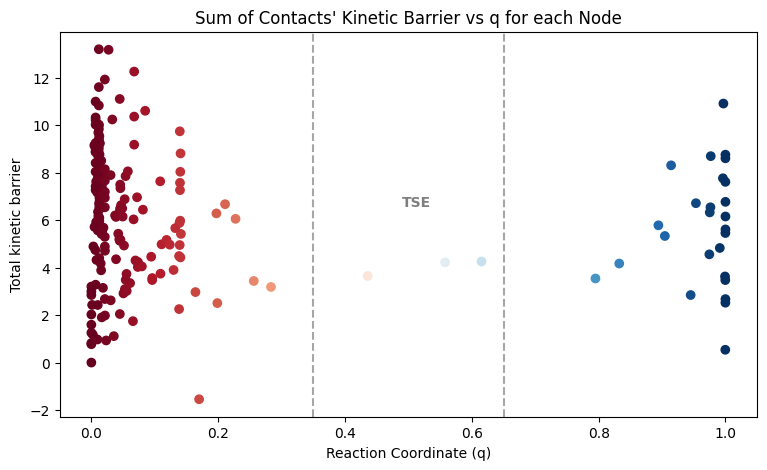

In [51]:
import pandas as pd 

def get_contacts_from_map(map):

    contact_pairs = []
    N = map.shape[0]
    for i in range(N):
        # Start j from i+1 to scan only the upper triangle (i < j)
        for j in range(i + 1, N):
            if map[i][j] == 1:
                contact_pairs.append((i, j))
    
    return contact_pairs

total_kinetics = {}
for i, contact_map_node in enumerate(unique_maps):
    res_pairs = get_contacts_from_map(contact_map_node)

    total_kinetic = 0
    for res_pair in res_pairs:
        try:
            total_kinetic += df[df["residue_pair"] == res_pair]["dG_rel_kcal_per_mol"].item()
        except: pass

    total_kinetics[i] = total_kinetic

df_q_vs_kin = pd.DataFrame({"q": q_map.values(), "k": total_kinetics.values()})

plt.subplots(figsize=(9,5))
plt.scatter(df_q_vs_kin["q"], df_q_vs_kin["k"], c=q_map.values(), cmap="RdBu")
plt.title("Sum of Contacts' Kinetic Barrier vs q for each Node")
plt.ylabel("Total kinetic barrier")
plt.xlabel("Reaction Coordinate (q)")
plt.axvline(0.35, linestyle="--", c="grey", alpha=0.7)
plt.axvline(0.65, linestyle="--", c="grey", alpha=0.7)
plt.text(0.85, 0.5, "TSE", transform=ax.transAxes, ha='center', va='bottom', fontweight='bold', alpha=0.5)
plt.savefig("images/chignolin_summed_kinetic_barrier_vs_q.png")

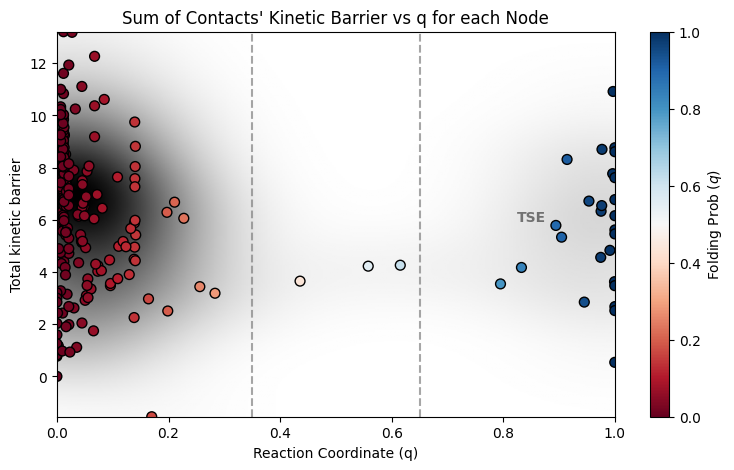

In [83]:
from scipy.stats import gaussian_kde

xy = np.vstack([df_q_vs_kin["q"], df_q_vs_kin["k"]])
kde = gaussian_kde(xy, bw_method=None)

# grid over data range
xmin, xmax = df_q_vs_kin["q"].min(), df_q_vs_kin["q"].max()
ymin, ymax = df_q_vs_kin["k"].min(), df_q_vs_kin["k"].max()
X, Y = np.meshgrid(np.linspace(xmin, xmax, 300),
                    np.linspace(ymin, ymax, 300))
positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

fig, ax = plt.subplots(figsize=(9,5))
im = ax.imshow(
    Z,
    extent=(xmin, xmax, ymin, ymax),
    origin='lower',
    aspect='auto',
    cmap="grey_r"
)
plt.scatter(df_q_vs_kin["q"], df_q_vs_kin["k"], c=q_map.values(), cmap="RdBu", linewidths=1, edgecolors="black", s=50)
plt.title("Sum of Contacts' Kinetic Barrier vs q for each Node")
plt.ylabel("Total kinetic barrier")
plt.xlabel("Reaction Coordinate (q)")
plt.axvline(0.35, linestyle="--", c="grey", alpha=0.7)
plt.axvline(0.65, linestyle="--", c="grey", alpha=0.7)
plt.text(0.85, 0.5, "TSE", transform=ax.transAxes, ha='center', va='bottom', fontweight='bold', alpha=0.5)
cbar = plt.colorbar()
cbar.set_label("Folding Prob ($q$)")
plt.savefig("images/chignolin_summed_kinetic_barrier_vs_q.png")

R-squared: 0.5976
P-value: 2.1356e-42


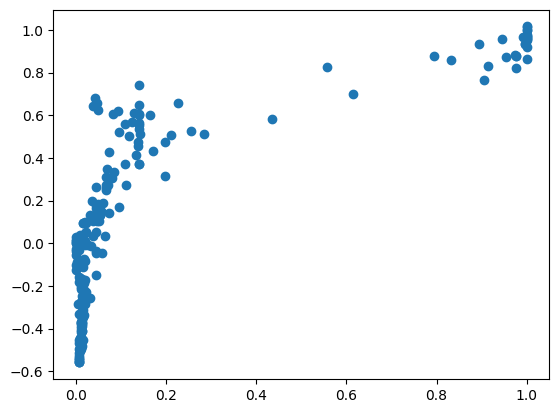

In [79]:
'''
embedded folding vector vs reaction coordinates 
'''

import numpy as np
import matplotlib.pyplot as plt

# 1. Define Unfolded and Folded clusters in Embedding Space
unfolded_indices = [n for n, q in q_map.items() if q < 0.1]
folded_indices   = [n for n, q in q_map.items() if q > 0.9]

# Get the centroids (mean position in X_emb)
U_centroid = np.mean(X_emb[[0]], axis=0)
F_centroid = np.mean(X_emb[[197]], axis=0)

# 2. Define the Folding Vector (U -> F)
folding_vector = F_centroid - U_centroid
norm = np.linalg.norm(folding_vector)
unit_vector = folding_vector / norm

# 3. Project every node onto this vector
# Formula: scalar_proj = (Point - U) dot Unit_Vector
# We normalize by the total length so 0 = Unfolded, 1 = Folded
geometric_rc = []
for point in X_emb:
    # Vector from Unfolded Center to current point
    rel_vec = point - U_centroid
    # Project onto the folding vector
    projection = np.dot(rel_vec, unit_vector)
    # Normalize (optional, makes it 0.0 to 1.0 approx)
    geometric_rc.append(projection / norm)

geometric_rc = np.array(geometric_rc)
plt.scatter(q_map.values(), geometric_rc)

from scipy import stats

# 1. Calculate the regression
slope, intercept, r_value, p_value, std_err = stats.linregress(geometric_rc, np.array(list(q_map.values())))

# 2. Square the r_value to get R^2
r_squared = r_value**2

print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")

R-squared: 0.1133
P-value: 7.0697e-07


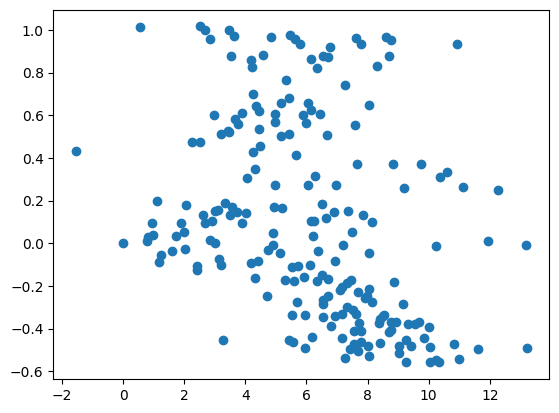

In [ ]:
plt.scatter(total_kinetics.values(), geometric_rc)

# 1. Calculate the regression
slope, intercept, r_value, p_value, std_err = stats.linregress(geometric_rc, np.array(list(total_kinetics.values())))

# 2. Square the r_value to get R^2
r_squared = r_value**2

print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")

/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


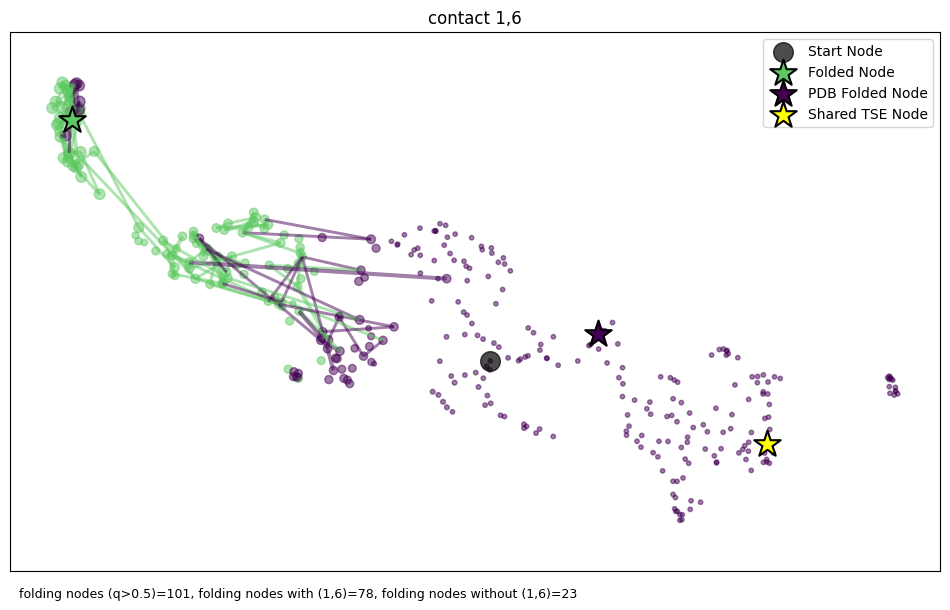

In [92]:
'''  
For all nodes with q > 0.5, do they have contact pair 1,6?
'''

import umap

folding_nodes = {}
all_nodes = {}
for n, q in q_map.items():
    contact_map = unique_maps[n]
    if contact_map[1,6] == 1:
        all_nodes[n] = 1
        if q > 0.5:
            folding_nodes[n] = 1
    else: 
        all_nodes[n] = 0
        if q > 0.5:
            folding_nodes[n] = 0


num_with = len(np.where(np.array(list(folding_nodes.values())) == 1)[0])
num_without = len(np.where(np.array(list(folding_nodes.values())) == 0)[0])

def embed_flat_bits(flat_bits, n_components=2, n_neighbors=15, random_state=42):
    """
    embed flat_bits (U, Mbits) -> X_emb (U,2)
    Prefer UMAP if available, else Isomap, else SpectralEmbedding, else PCA.
    """
    U = flat_bits.shape[0]
    X = flat_bits.astype(float)  # scikit-learn expects float arrays
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
    X_emb = reducer.fit_transform(X)
    return X_emb

X_emb = embed_flat_bits(flat_bits, n_neighbors=15)
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}

def pairs_and_widths_from_edges(edges, pos, base_w=1.0, scale_w=1.2):
        '''
        edges may be list-of-pairs OR Counter   
        returns: segs ([(p0,p1),...]), widths ([w,...])
        '''
        from collections import Counter
        if isinstance(edges, Counter):
            items = list(edges.items())  # [((a,b), count), ...]
            segs = [((pos[a][0], pos[a][1]), (pos[b][0], pos[b][1])) for (a,b), _ in items]
            widths = [base_w + scale_w * np.sqrt(c) for (_, c) in items]
        else:
            # list of pairs
            segs = [((pos[a][0], pos[a][1]), (pos[b][0], pos[b][1])) for a,b in edges]
            widths = [2.0] * len(segs)  # old fixed widths
        return segs, widths

folding_nodes_idxs = list(folding_nodes.keys())
folding_nodes_edges = plotting.expand_seq_to_edges(G, folding_nodes_idxs, True, count_multiplicity=True)

#segs, widths = plotting.pairs_and_widths_from_edges(folding_nodes_edges, pos, base_w=1.0, scale_w=1.2)
folding_segs, widths = pairs_and_widths_from_edges(folding_nodes_edges, pos, base_w=0.1, scale_w=2)

# get edge colors based on destination node value
edge_colors = []
for edge, count in folding_nodes_edges.items():
    dest_val = folding_nodes.get(edge[1], 0) 
    edge_colors.append("#5EC962" if dest_val == 1 else "#440154")

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))

# green means contact present, purple means not present
colors = ["#5EC962" if all_nodes[n] == 1 else "#440154" for n in all_nodes.keys()]
sizes = 10 + 50*np.array(list(q_map.values()))
ax.scatter(X_emb[list(all_nodes.keys()),0], X_emb[list(all_nodes.keys()),1], c=colors, s=sizes, alpha=0.5)

#colors = ["#5EC962" if folding_nodes[n] == 0 else "#440154" for n in folding_nodes_idxs]
#ax.scatter(X_emb[folding_nodes_idxs,0], X_emb[folding_nodes_idxs,1], c=colors, s=50, alpha=0.5)

ax.scatter(X_emb[start_node,0], X_emb[start_node,1], c="black", s=200, label="Start Node", alpha=0.7)
ax.scatter(X_emb[folded_node,0], X_emb[folded_node,1], c=colors[folded_node], s=400, marker="*", linewidths=1.5, edgecolors="black", label="Folded Node", zorder=20)

ax.scatter(X_emb[197,0], X_emb[197,1], c=colors[197], s=400, marker="*", linewidths=1.5, edgecolors="black", label="PDB Folded Node", zorder=30)

# pos 117 is only position shared between q-based TSE and betweeness centrality TSE
ax.scatter(pos[117][0], pos[117][1], c="yellow", marker='*', s=400, edgecolors='black', linewidths=1.5, zorder=21, label="Shared TSE Node")

lc = LineCollection(folding_segs, colors=edge_colors, linewidths=widths, zorder=6, alpha=0.5)
ax.add_collection(lc)

ax.set_aspect('equal', adjustable='datalim')
ax.set_xticks([]); ax.set_yticks([])
ax.set_title("contact 1,6")

# debug text
dbg = f"folding nodes (q>0.5)={len(folding_nodes_idxs)}, folding nodes with (1,6)={num_with}, folding nodes without (1,6)={num_without}"
ax.text(0.01, -0.03, dbg, transform=ax.transAxes, fontsize=9, va='top')

plt.legend()
plt.show()